Enter the file name you want to test with the extension .jpg or .png: test1.jpg
0. Off
1. on
Debug mode: 0
0. Off
1. on
Save mode: 0
36
[ 6 10 33  5 30 32 20  3 14 31 23 12  7  4  2 25 13 22 21 26 11 18  9  1
  0 17 27 24 35 19  8 16 34 29 15 28]
7
This is the extracted plate number: CAA1454


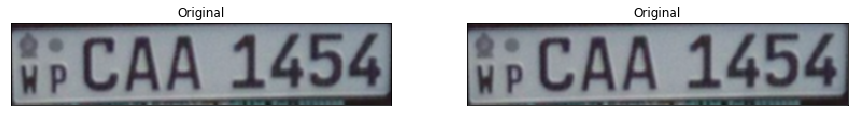

In [67]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from imutils import contours
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

def plot_images(img1, img2, title1 = "", title2= ""):
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap = "gray")
    ax1.set(xticks=[], yticks=[], title=title1)
    
    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap = "gray")
    ax2.set(xticks=[], yticks=[], title=title2)


def find_max(arr):
    temp = []
    arrList = list(arr)
    for i in range(len(arr)):
        temp.append(arrList.count(arr[i]))  #saves # of occurances of each hight value
    indexMaxValue = temp.index(max(temp))
    maxValue = arrList[indexMaxValue]  #find the index of the max value in arrList
    return maxValue

fileName = str(input("Enter the file name you want to test with the extension .jpg or .png: "))
path = str("./"+ str(fileName))

path = "./test1.jpg"           #Path to the image
userInput = int(input("0. Off\n1. on\nDebug mode: "))
#open the path to the image
image = cv2.imread(path)
saveInput = int(input("0. Off\n1. on\nSave mode: "))
if(userInput):
    plot_images(image, image, title1 = "Original", title2 = "Original")

#grayscale image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
if(userInput):
    plot_images(image, gray, title1 = "Original", title2="Gray")

#blurred image
blur = cv2.bilateralFilter(gray, 11, 90, 90)
if(userInput):
    plot_images(gray, blur, title1="Gray", title2="Blur")

#get the edges from the image
edges = cv2.Canny(blur, 30, 200)
if(userInput):
    plot_images(blur, edges, title1="Blur", title2="Edge")

#Extract the contours form the image
cntr, new = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
image_copy = image.copy()
_ = cv2.drawContours(image_copy, cntr, -1, (255,0, 255), 1)
if(userInput):
    plot_images(edges, image_copy, title1 = "Edges", title2 = "Contours")

cnts = sorted(cntr, key = cv2.contourArea, reverse=True)[:15]
image_reduced_cnts = image.copy()
_= cv2.drawContours(image_reduced_cnts, cnts, -1, (255, 0, 255), 2)
if (userInput):
    plot_images(image_copy, image_reduced_cnts, title1 = "Contours", title2 = "Reduced")

#extract the plat from the image
plate = None
for c in cnts:
    perimeter = cv2.arcLength(c, True)
    edge_count = cv2.approxPolyDP(c, 0.02*perimeter, True)
    if len(edge_count)== 4:
        x,y,w,h = cv2.boundingRect(c)
        plate = image[y:y+h, x:x+w]
        break

#print the plate
cv2.imwrite("plate.jpg", plate)
if(userInput):
    plot_images(plate, plate, title1 = "Plate", title2 = "Plate")





platChar = []

image = cv2.imread("forTraining.png")    #open the image to train the kmeans algorithm

#create a mask to help extract the alphabets from the image
mask = np.zeros(image.shape, dtype=np.uint8)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
if(userInput):
    plot_images(image, gray, title1="Original", title2="Gray")
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
(cnts, _) = contours.sort_contours(cnts, method="left-to-right")


#find the width and hight of the the images with acceptable area
ROI_number = 0    #this values is used to name the images when they are written to memory
width = []        #saves the width of the images
hight = []         #saves the hight of the images

for c in cnts:
    area = cv2.contourArea(c)
    if area < 2000 and area > 45:
        x,y,w,h = cv2.boundingRect(c)
        width.append(w)
        hight.append(h)
        
#calculat the minimum width and hight of the characters
min_width = find_max(width)-3
min_hight = find_max(hight)-3
if(userInput):
    print("This is minimum width " + str(min_width))
    print("This is minimum hight " + str(min_hight))


for c in cnts:
    area = cv2.contourArea(c)
    if area < 2000 and area > 50:
        x,y,w,h = cv2.boundingRect(c)
        ROI = 255 - thresh[y:y+h+2, x:x+w+2]
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        if(h>min_hight):
            if(saveInput):
                cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
            platChar.append(ROI)
            ROI_number += 1
            
if(userInput):
    plot_images(mask, thresh, title1="Mask", title2="Thresh")

#resize all the extracted images
for i in range(len(platChar)):
    platChar[i] = cv2.resize(platChar[i], (28, 28))
print(len(platChar))
platChar[1].shape



platChar = np.reshape(platChar, (len(platChar), 784))
kmeans = KMeans(n_clusters=36)
model = kmeans.fit(platChar)
tempModel = model.labels_

print(tempModel)

# plot_images(platChar[0].reshape(28, 28), platChar[4].reshape(28, 28), title1 ="Y", title2="Y" )
if(userInput):
    for i in range(len(platChar)):
        plot_images(platChar[i].reshape(28, 28), platChar[i].reshape(28, 28))
    
#label string for all the images
img_label = "ASBTCUVDWEFXGYZHI0J1K2L3M4N5O6P7Q89R"



plate_num = []

image = cv2.imread('plate.jpg')    #open the image to train the kmeans algorithm
image = cv2.GaussianBlur(image,(5,5),0)
if(userInput):
    plot_images(image, image, title1 = "Original", title2 = "Original")

#create a mask to help extract the alphabets from the image
mask = np.zeros(image.shape, dtype=np.uint8)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
if(userInput):
    plot_images(mask, gray, title1="Mask", title2="Gray")
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
(cnts, _) = contours.sort_contours(cnts, method="left-to-right")



#find the width and hight of the the images with acceptable area
ROI_number = 0    #this values is used to name the images when they are written to memory
width = []        #saves the width of the images
hight = []         #saves the hight of the images

for c in cnts:
    area = cv2.contourArea(c)
    if area < 2000 and area > 40:
        x,y,w,h = cv2.boundingRect(c)
        width.append(w)
        hight.append(h)


#calculat the minimum width and hight of the characters
min_width = find_max(width)-3
min_hight = find_max(hight)-3
if(userInput):
    print("This is minimum width " + str(min_width))
    print("This is minimum hight " + str(min_hight))


for c in cnts:
    area = cv2.contourArea(c)
    if area < 2000 and area > 40:
        x,y,w,h = cv2.boundingRect(c)
        #print("X "+str(x) + " Y: " + str(y)+ " W: " + str(w)+ " H: " + str(h))
        ROI = 255 - thresh[y:y+h, x:x+w]
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        if(w>min_width and h>min_hight):
            if(saveInput):
                cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
            plate_num.append(ROI)
            ROI_number += 1

if(userInput):
    plot_images(mask, thresh, title1="Mask", title2="Thresh")

print(len(plate_num))

#Reshape
for i in range(len(plate_num)):
    plate_num[i] = cv2.resize(plate_num[i], (28, 28))
plate_num[1].shape


#print
if(userInput):
    for i in range(len(plate_num)):
        plot_images(plate_num[i], plate_num[i])

predict = model.predict(plate_num[0].reshape(1, 784))



#predit all the charcters extracted from the plate
predicted_label_number = []
licence_plate = ""
for i in range(len(plate_num)):
    predict = model.predict(plate_num[i].reshape(1, 784))
    predicted_label_number.append(predict)                            #saves all the label numbers in the array
    location_index = np.where(tempModel == int(predict))              #find the index of the predicted label
    licence_plate += img_label[location_index[0][0]]                        #use location_index to find the label for the image

plot_images(image, image, title1 = "Original", title2 = "Original")
print("This is the extracted plate number: " + licence_plate)



